# Demo of the GTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_42398/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_42398/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_42398/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
model = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
study = model.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


[I 2025-10-07 16:45:00,086] A new study created in RDB with name: no-name-e69b2b7d-f64a-4281-a6f4-3b57c092345b
  0%|          | 0/2000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<05:14,  6.35it/s]

current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3849, grad_fn=<MeanBackward0>)
current_loss_val:  1.3795946836471558
current_loss: tensor(1.3849, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:45,  5.79it/s]

current_loss: tensor(1.3346, grad_fn=<MeanBackward0>)
current_loss_val:  1.3102284669876099
current_loss: tensor(1.3346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:00,  3.69it/s]

current_loss_val:  1.2939802408218384
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:12,  3.26it/s]

current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss_val:  1.2881863117218018
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:06,  4.67it/s]

current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss_val:  1.2841626405715942
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss_val:  1.2808541059494019


  0%|          | 7/2000 [00:01<06:03,  5.48it/s]

current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss_val:  1.2768629789352417
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:52,  6.80it/s]

current_loss_val:  1.2736268043518066
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss_val:  1.2690260410308838
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:33,  7.27it/s]

current_loss_val:  1.260428786277771
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss_val:  1.2569667100906372
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<04:14,  7.80it/s]

current_loss_val:  1.2576171159744263
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss_val:  1.2577836513519287
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 15/2000 [00:02<04:15,  7.77it/s]

tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss_val:  1.2582346200942993
current_loss: tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss_val:  1.2582100629806519


  1%|          | 15/2000 [00:02<05:46,  5.72it/s]
[I 2025-10-07 16:45:06,407] Trial 0 finished with value: -2.5139336585998535 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.162428721272082, 'penalty_decorrelation_ridge_second_difference': 19.106642282979738}. Best is trial 0 with value: -2.5139336585998535.


current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss_val:  1.2586649656295776
Early Stop at iteration 15 with minimal loss tensor(1.2570) and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<05:04,  6.56it/s]

current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, grad_fn=<MeanBackward0>)
current_loss_val:  1.2567822933197021
current_loss: tensor(1.2832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:19, 10.00it/s]

current_loss_val:  1.2566760778427124
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss_val:  1.2556641101837158
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554891109466553
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:07, 10.63it/s]

current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551589012145996
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550077438354492
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:04, 10.79it/s]

current_loss_val:  1.2548472881317139
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss_val:  1.2546086311340332
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544488906860352


  0%|          | 10/2000 [00:00<03:04, 10.76it/s]

current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542885541915894
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543526887893677
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:05, 10.73it/s]

current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547719478607178
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss_val:  1.254510760307312
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:05, 10.69it/s]

current_loss_val:  1.2541230916976929
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.2533196210861206
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:16, 10.11it/s]

current_loss_val:  1.2528588771820068
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525893449783325
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:37,  9.13it/s]

current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.2512565851211548
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss_val:  1.2506320476531982
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:19,  9.91it/s]

current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.2505989074707031
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.25050687789917
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:37,  9.07it/s]

current_loss_val:  1.250380039215088
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.2502769231796265
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:44,  8.82it/s]

current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2502264976501465
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2495145797729492
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:31,  9.32it/s]

current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss_val:  1.2479623556137085
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss_val:  1.247775912284851
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:29,  9.40it/s]

current_loss_val:  1.2473714351654053
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss_val:  1.2469450235366821
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:48,  8.62it/s]

current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss_val:  1.245945930480957
current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss_val:  1.2455388307571411
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:32,  9.25it/s]

current_loss_val:  1.2452201843261719
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss_val:  1.2443751096725464
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:47,  8.64it/s]

current_loss_val:  1.2415515184402466
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.2414134740829468
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:49,  8.56it/s]

current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss_val:  1.241444706916809
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss_val:  1.241491436958313


  2%|▏         | 38/2000 [00:04<04:32,  7.20it/s]

current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss_val:  1.2418688535690308
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss_val:  1.2418363094329834
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:38,  8.97it/s]
[I 2025-10-07 16:45:10,901] Trial 1 finished with value: -2.4828269481658936 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.620527886965721, 'penalty_decorrelation_ridge_second_difference': 18.405654682057836}. Best is trial 1 with value: -2.4828269481658936.


current_loss_val:  1.2417820692062378
Early Stop at iteration 39 with minimal loss tensor(1.2414) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:54,  8.54it/s]

current_loss: tensor(1.2883, grad_fn=<MeanBackward0>)
current_loss_val:  1.2567648887634277
current_loss: tensor(1.2883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss_val:  1.2566626071929932
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:14, 10.26it/s]

current_loss_val:  1.2560060024261475
current_loss: tensor(1.2816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)
current_loss_val:  1.2563406229019165
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:38,  9.15it/s]

current_loss_val:  1.2561113834381104
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, grad_fn=<MeanBackward0>)
current_loss_val:  1.256476640701294
current_loss: tensor(1.2768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:11, 10.43it/s]

current_loss_val:  1.256648063659668
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:42,  8.94it/s]
[I 2025-10-07 16:45:11,797] Trial 2 finished with value: -2.512012243270874 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.554403565261685, 'penalty_decorrelation_ridge_second_difference': 15.607161264771822}. Best is trial 1 with value: -2.4828269481658936.


current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss_val:  1.2566630840301514
Early Stop at iteration 7 with minimal loss tensor(1.2560) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:39,  9.09it/s]

current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss_val:  1.256554365158081
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss_val:  1.2563608884811401
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:10, 10.51it/s]

current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554399967193604
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544143199920654
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:25,  9.73it/s]

current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538459300994873
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525782585144043
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:57, 11.22it/s]

current_loss_val:  1.2525893449783325
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2529170513153076
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2522021532058716
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:50, 11.68it/s]

current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520039081573486
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.2516218423843384
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss_val:  1.251244068145752


  1%|          | 13/2000 [00:01<02:43, 12.15it/s]

current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss_val:  1.250899314880371
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2508589029312134
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:49, 11.73it/s]

current_loss_val:  1.2505714893341064
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2499555349349976
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2498598098754883
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2498478889465332
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:09, 10.46it/s]

current_loss_val:  1.2497185468673706
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss_val:  1.2493468523025513


  1%|          | 21/2000 [00:02<03:35,  9.18it/s]

current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss_val:  1.2493246793746948
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss_val:  1.2493709325790405
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<04:09,  7.91it/s]

current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss_val:  1.2491978406906128
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<05:06,  6.44it/s]

current_loss_val:  1.249086856842041
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss_val:  1.2490150928497314
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss_val:  1.2481533288955688


  1%|▏         | 27/2000 [00:02<04:03,  8.09it/s]

current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss_val:  1.2461847066879272
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss_val:  1.2458438873291016
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:41,  8.89it/s]

current_loss_val:  1.2451170682907104
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss_val:  1.243675947189331
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss_val:  1.243056058883667


  2%|▏         | 34/2000 [00:03<02:55, 11.19it/s]

current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss_val:  1.2401936054229736
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss_val:  1.239952802658081
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss_val:  1.2401467561721802


  2%|▏         | 36/2000 [00:03<02:49, 11.56it/s]

current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss_val:  1.2401540279388428
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss_val:  1.2401682138442993
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:26,  9.52it/s]
[I 2025-10-07 16:45:15,803] Trial 3 finished with value: -2.479905605316162 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.401214712804881, 'penalty_decorrelation_ridge_second_difference': 9.645086254352977}. Best is trial 3 with value: -2.479905605316162.


current_loss_val:  1.2404946088790894
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss_val:  1.240372896194458
Early Stop at iteration 37 with minimal loss tensor(1.2400) and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<03:44,  8.90it/s]

current_loss: tensor(1.3072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3027, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568615674972534
current_loss: tensor(1.3027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568156719207764
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 5/2000 [00:00<02:32, 13.10it/s]

tensor(1.2918, grad_fn=<MeanBackward0>)
current_loss_val:  1.257284164428711
current_loss: tensor(1.2918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, grad_fn=<MeanBackward0>)
current_loss_val:  1.2587251663208008
current_loss: tensor(1.2912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, grad_fn=<MeanBackward0>)
current_loss_val:  1.2581911087036133
current_loss: tensor(1.2866, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:05, 10.75it/s]


current_loss: tensor(1.2859, grad_fn=<MeanBackward0>)
current_loss_val:  1.2580962181091309
current_loss: tensor(1.2859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)
current_loss_val:  1.2579889297485352
Early Stop at iteration 6 with minimal loss tensor(1.2568) and patience 5 and min_delta 1e-07


[I 2025-10-07 16:45:16,795] Trial 4 finished with value: -2.5136313438415527 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.996274952597386, 'penalty_decorrelation_ridge_second_difference': 20.44049336232288}. Best is trial 3 with value: -2.479905605316162.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:26,  3.53it/s]

current_loss_val:  1.2565960884094238
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2563945055007935


  0%|          | 3/2000 [00:00<07:21,  4.52it/s]

current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548748254776
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<04:30,  7.37it/s]

current_loss_val:  1.2527568340301514
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519792318344116
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss_val:  1.2517688274383545


  0%|          | 8/2000 [00:01<03:48,  8.72it/s]

current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss_val:  1.2509663105010986
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss_val:  1.2507150173187256
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:27,  9.60it/s]

current_loss_val:  1.2501240968704224
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss_val:  1.249968409538269
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss_val:  1.2495851516723633


  1%|          | 12/2000 [00:01<03:21,  9.85it/s]

current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss_val:  1.2487345933914185
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)
current_loss_val:  1.2478501796722412


  1%|          | 15/2000 [00:01<03:21,  9.86it/s]

current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss_val:  1.2465826272964478
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)
current_loss_val:  1.2455617189407349
current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<03:09, 10.46it/s]

current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss_val:  1.2449467182159424
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss_val:  1.2439897060394287
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss_val:  1.2429808378219604


  1%|          | 20/2000 [00:02<04:22,  7.53it/s]

current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss_val:  1.2405784130096436
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss_val:  1.2398585081100464


  1%|          | 22/2000 [00:02<03:34,  9.20it/s]

current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss_val:  1.239687442779541
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss_val:  1.23921799659729
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss_val:  1.2386415004730225
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<02:50, 11.59it/s]

current_loss_val:  1.2384158372879028
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss_val:  1.2381633520126343
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss_val:  1.2379130125045776
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<02:52, 11.46it/s]

current_loss_val:  1.2378342151641846
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss_val:  1.2377675771713257
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss_val:  1.2375861406326294


  2%|▏         | 30/2000 [00:03<03:11, 10.29it/s]

current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss_val:  1.2384206056594849
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss_val:  1.237725019454956
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<02:57, 11.09it/s]

current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss_val:  1.2376680374145508
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss_val:  1.2376779317855835
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:47,  8.66it/s]
[I 2025-10-07 16:45:20,762] Trial 5 finished with value: -2.475172281265259 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1644381437597984, 'penalty_decorrelation_ridge_second_difference': 12.272204382124142}. Best is trial 5 with value: -2.475172281265259.


current_loss_val:  1.2378634214401245
Early Stop at iteration 33 with minimal loss tensor(1.2376) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:56, 11.29it/s]

current_loss_val:  1.256820797920227
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss_val:  1.256726861000061
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:07, 10.66it/s]

current_loss_val:  1.2559535503387451
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552111148834229
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss_val:  1.2551391124725342
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.16it/s]

current_loss_val:  1.2550249099731445
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss_val:  1.2548270225524902
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543697357177734
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541896104812622


  0%|          | 10/2000 [00:00<02:22, 13.97it/s]

current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss_val:  1.2539888620376587
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543367147445679
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:17, 14.50it/s]

current_loss_val:  1.2550190687179565
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:13, 14.91it/s]

current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.254711389541626
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543498277664185
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536119222640991
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:06, 15.61it/s]

current_loss_val:  1.2533037662506104
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530890703201294
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.252079725265503
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.251706600189209
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<01:58, 16.67it/s]

current_loss_val:  1.2517598867416382
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.25179123878479
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.251846194267273
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:24, 13.71it/s]


current_loss_val:  1.2519643306732178
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.252011775970459
Early Stop at iteration 23 with minimal loss tensor(1.2517) and patience 5 and min_delta 1e-07


[I 2025-10-07 16:45:22,560] Trial 6 finished with value: -2.503413200378418 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.501588386612947, 'penalty_decorrelation_ridge_second_difference': 22.73665761707029}. Best is trial 5 with value: -2.475172281265259.
  0%|          | 1/2000 [00:00<03:35,  9.26it/s]

current_loss: tensor(1.2930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss_val:  1.256866693496704
current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2879, grad_fn=<MeanBackward0>)
current_loss_val:  1.256800889968872
current_loss: tensor(1.2879, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 5/2000 [00:00<02:42, 12.28it/s]

tensor(1.2835, grad_fn=<MeanBackward0>)
current_loss_val:  1.256442666053772
current_loss: tensor(1.2835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561092376708984
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, grad_fn=<MeanBackward0>)
current_loss_val:  1.256044864654541


  0%|          | 7/2000 [00:00<02:40, 12.44it/s]

current_loss: tensor(1.2804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559607028961182
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558385133743286
current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:36, 12.69it/s]

current_loss_val:  1.2555367946624756
current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555491924285889
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss_val:  1.2558138370513916
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:49, 11.71it/s]

current_loss_val:  1.2565317153930664
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss_val:  1.2575920820236206
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss_val:  1.2576003074645996
Early Stop at iteration 12 with minimal loss tensor(1.2555) and patience 5 and min_delta 1e-07



[I 2025-10-07 16:45:23,694] Trial 7 finished with value: -2.5110738277435303 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.58364236498753, 'penalty_decorrelation_ridge_second_difference': 26.642875233330862}. Best is trial 5 with value: -2.475172281265259.
  0%|          | 2/2000 [00:00<02:35, 12.84it/s]

current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568515539169312
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568172216415405
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss_val:  1.2578651905059814


  0%|          | 4/2000 [00:00<02:25, 13.71it/s]

current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss_val:  1.2587484121322632
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, grad_fn=<MeanBackward0>)
current_loss_val:  1.2593724727630615
current_loss: tensor(1.2880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:55, 11.35it/s]
[I 2025-10-07 16:45:24,337] Trial 8 finished with value: -2.513634443283081 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.714374720865173, 'penalty_decorrelation_ridge_second_difference': 17.181338645294257}. Best is trial 5 with value: -2.475172281265259.


current_loss_val:  1.26157808303833
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss_val:  1.2622934579849243
Early Stop at iteration 6 with minimal loss tensor(1.2568) and patience 5 and min_delta 1e-07


  0%|          | 3/2000 [00:00<02:22, 14.04it/s]

current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568217515945435
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss_val:  1.2567447423934937
current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, grad_fn=<MeanBackward0>)
current_loss_val:  1.2564352750778198


  0%|          | 5/2000 [00:00<02:07, 15.60it/s]

current_loss: tensor(1.2849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss_val:  1.2567743062973022
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565629482269287
current_loss: tensor(1.2812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss_val:  1.2564665079116821
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<01:55, 17.28it/s]

current_loss_val:  1.256331205368042
current_loss: tensor(1.2801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561672925949097
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561862468719482
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss_val:  1.256290078163147
current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:13, 14.87it/s]

current_loss_val:  1.2567384243011475
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss_val:  1.2577223777770996
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss_val:  1.257738471031189
Early Stop at iteration 12 with minimal loss tensor(1.2562) and patience 5 and min_delta 1e-07



[I 2025-10-07 16:45:25,264] Trial 9 finished with value: -2.5123345851898193 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.34240850793371, 'penalty_decorrelation_ridge_second_difference': 19.34372422568841}. Best is trial 5 with value: -2.475172281265259.
  0%|          | 2/2000 [00:00<02:41, 12.35it/s]

current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss_val:  1.25653874874115
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2563258409500122
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.36it/s]

current_loss_val:  1.2553672790527344
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541030645370483
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss_val:  1.253410816192627
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.92it/s]

current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2516037225723267
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss_val:  1.2510281801223755
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss_val:  1.25093412399292


  0%|          | 10/2000 [00:00<02:25, 13.69it/s]

current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss_val:  1.2506020069122314
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss_val:  1.2498350143432617
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss_val:  1.248652696609497
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:09, 15.32it/s]

current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss_val:  1.2472625970840454
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss_val:  1.2469431161880493
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss_val:  1.2467541694641113
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.2459931373596191


  1%|          | 16/2000 [00:01<02:16, 14.53it/s]

current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss_val:  1.244832992553711
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss_val:  1.2443718910217285


  1%|          | 18/2000 [00:01<02:48, 11.75it/s]

current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss_val:  1.2416359186172485
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:34,  9.24it/s]

current_loss_val:  1.2403515577316284
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss_val:  1.2399439811706543
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<03:21,  9.80it/s]

current_loss_val:  1.2397578954696655
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss_val:  1.2389566898345947
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss_val:  1.2386337518692017
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:06, 10.60it/s]

current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss_val:  1.238487958908081
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss_val:  1.2381467819213867
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:22,  9.73it/s]

current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss_val:  1.2380343675613403
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss_val:  1.2379306554794312
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:57, 11.10it/s]

current_loss_val:  1.2376524209976196
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss_val:  1.2378222942352295
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss_val:  1.237740159034729
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:53, 11.34it/s]

current_loss_val:  1.2378536462783813
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss_val:  1.2377281188964844
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss_val:  1.2377394437789917
Early Stop at iteration 32 with minimal loss tensor(1.2377) and patience 5 and min_delta 1e-07



[I 2025-10-07 16:45:28,194] Trial 10 finished with value: -2.47530460357666 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.383916865299073, 'penalty_decorrelation_ridge_second_difference': 10.279446437458303}. Best is trial 5 with value: -2.475172281265259.
  0%|          | 2/2000 [00:00<02:42, 12.31it/s]

current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568950653076172
current_loss: tensor(1.2974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568494081497192
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2900, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:19, 14.33it/s]

current_loss_val:  1.2567945718765259
current_loss: tensor(1.2900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss_val:  1.2569499015808105
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss_val:  1.2569242715835571
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss_val:  1.256900668144226


  0%|          | 7/2000 [00:00<02:33, 13.01it/s]
[I 2025-10-07 16:45:28,822] Trial 11 finished with value: -2.5135889053344727 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.675837191451478, 'penalty_decorrelation_ridge_second_difference': 28.740145071287767}. Best is trial 5 with value: -2.475172281265259.


current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568727731704712
current_loss: tensor(1.2836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568496465682983
Early Stop at iteration 7 with minimal loss tensor(1.2568) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3128, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:39, 12.55it/s]

current_loss: tensor(1.3245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568931579589844
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss_val:  1.256862759590149
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss_val:  1.2574865818023682


  0%|          | 6/2000 [00:00<02:13, 14.97it/s]

current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss_val:  1.2589986324310303
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, grad_fn=<MeanBackward0>)
current_loss_val:  1.2586365938186646
current_loss: tensor(1.2896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, grad_fn=<MeanBackward0>)
current_loss_val:  1.2585535049438477
current_loss: tensor(1.2886, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:37, 12.69it/s]
[I 2025-10-07 16:45:29,377] Trial 12 finished with value: -2.513725519180298 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.63876551592081, 'penalty_decorrelation_ridge_second_difference': 23.55849080796138}. Best is trial 5 with value: -2.475172281265259.


current_loss: tensor(1.2879, grad_fn=<MeanBackward0>)
current_loss_val:  1.25850248336792
Early Stop at iteration 6 with minimal loss tensor(1.2569) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss_val:  1.256563663482666
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:12, 15.03it/s]

current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss_val:  1.256368637084961
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553420066833496
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.15it/s]

current_loss_val:  1.2543171644210815


  0%|          | 6/2000 [00:00<02:20, 14.24it/s]

current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536969184875488
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.2523139715194702
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.2522740364074707
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:29,  9.51it/s]

current_loss_val:  1.2523361444473267
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:14, 10.21it/s]

current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520573139190674
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss_val:  1.2510796785354614
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2498944997787476
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:53, 11.43it/s]

current_loss_val:  1.248035192489624
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss_val:  1.2475872039794922
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:41, 12.28it/s]

current_loss_val:  1.247111201286316
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss_val:  1.245436429977417


  1%|          | 16/2000 [00:01<02:27, 13.41it/s]

current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss_val:  1.2432231903076172
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss_val:  1.2419283390045166


  1%|          | 18/2000 [00:01<02:21, 14.05it/s]

current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss_val:  1.2402735948562622
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:12, 14.91it/s]

current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss_val:  1.2393819093704224
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss_val:  1.2390921115875244
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss_val:  1.2385504245758057
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:14, 14.66it/s]

current_loss_val:  1.2385554313659668
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss_val:  1.2382290363311768


  1%|▏         | 26/2000 [00:02<02:36, 12.62it/s]

current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss_val:  1.237964153289795
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss_val:  1.238338828086853
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss_val:  1.2387089729309082
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:38, 12.41it/s]


current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss_val:  1.2388190031051636
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss_val:  1.2386455535888672
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss_val:  1.2382153272628784
Early Stop at iteration 28 with minimal loss tensor(1.2380) and patience 5 and min_delta 1e-07


[I 2025-10-07 16:45:31,719] Trial 13 finished with value: -2.47592830657959 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.7617978264420096, 'penalty_decorrelation_ridge_second_difference': 10.104388343152813}. Best is trial 5 with value: -2.475172281265259.
  0%|          | 1/2000 [00:00<03:20,  9.99it/s]

current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss_val:  1.2567670345306396
current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, grad_fn=<MeanBackward0>)
current_loss_val:  1.2566640377044678
current_loss: tensor(1.2866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:24, 13.83it/s]

current_loss_val:  1.2559285163879395
current_loss: tensor(1.2812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562192678451538
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559735774993896
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:41, 12.31it/s]
[I 2025-10-07 16:45:32,374] Trial 14 finished with value: -2.5118567943573 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.060512075929159, 'penalty_decorrelation_ridge_second_difference': 15.943271792733935}. Best is trial 5 with value: -2.475172281265259.


current_loss_val:  1.2563315629959106
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, grad_fn=<MeanBackward0>)
current_loss_val:  1.2564820051193237
current_loss: tensor(1.2761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss_val:  1.2564573287963867
Early Stop at iteration 7 with minimal loss tensor(1.2559) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<02:11, 15.19it/s]

current_loss: tensor(1.2880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565170526504517
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, grad_fn=<MeanBackward0>)
current_loss_val:  1.2563811540603638
current_loss: tensor(1.2835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss_val:  1.256256103515625


  0%|          | 6/2000 [00:00<02:16, 14.65it/s]

current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss_val:  1.2554659843444824
current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss_val:  1.2552056312561035
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss_val:  1.255645513534546


  0%|          | 8/2000 [00:00<02:12, 15.09it/s]

current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss_val:  1.2566609382629395
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss_val:  1.2571135759353638
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568038702011108
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:26, 13.55it/s]
[I 2025-10-07 16:45:33,132] Trial 15 finished with value: -2.5104117393493652 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.540777523481236, 'penalty_decorrelation_ridge_second_difference': 4.024038952969963}. Best is trial 5 with value: -2.475172281265259.


current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562679052352905
Early Stop at iteration 9 with minimal loss tensor(1.2552) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.256237506866455
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<01:53, 17.60it/s]

current_loss_val:  1.2552595138549805
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535943984985352
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<01:58, 16.81it/s]

current_loss_val:  1.2513536214828491
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss_val:  1.2515978813171387
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<01:53, 17.50it/s]

current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss_val:  1.2512959241867065
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss_val:  1.250937581062317
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<01:54, 17.34it/s]

current_loss_val:  1.2478160858154297
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss_val:  1.2473742961883545


  0%|          | 10/2000 [00:00<01:53, 17.52it/s]

current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss_val:  1.2475388050079346
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss_val:  1.2484394311904907
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<01:52, 17.66it/s]

current_loss_val:  1.24811589717865
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<01:58, 16.72it/s]

current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss_val:  1.2470284700393677
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss_val:  1.2453668117523193
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss_val:  1.244760274887085


  1%|          | 16/2000 [00:00<01:57, 16.87it/s]

current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss_val:  1.2433961629867554


  1%|          | 18/2000 [00:01<02:00, 16.44it/s]

current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss_val:  1.2427743673324585
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss_val:  1.2426666021347046
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss_val:  1.2407050132751465
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:04, 15.89it/s]

current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss_val:  1.2404521703720093
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss_val:  1.2400270700454712
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:11, 15.08it/s]

current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss_val:  1.2388347387313843


  1%|          | 24/2000 [00:01<02:04, 15.84it/s]

current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss_val:  1.2381130456924438
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss_val:  1.2381250858306885
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss_val:  1.238369345664978
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:01<02:04, 15.89it/s]

current_loss_val:  1.238694429397583
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss_val:  1.2387088537216187
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss_val:  1.238655924797058
Early Stop at iteration 27 with minimal loss tensor(1.2381) and patience 5 and min_delta 1e-07



[I 2025-10-07 16:45:34,917] Trial 16 finished with value: -2.4762260913848877 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.5982590418706657, 'penalty_decorrelation_ridge_second_difference': 2.4424867582878003}. Best is trial 5 with value: -2.475172281265259.
  0%|          | 2/2000 [00:00<02:44, 12.18it/s]

current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.256683349609375
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.256514549255371
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:45, 12.06it/s]

current_loss_val:  1.2547545433044434
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542184591293335
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538118362426758
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:38, 12.61it/s]

current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss_val:  1.2510725259780884
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss_val:  1.2508481740951538
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss_val:  1.250856876373291


  0%|          | 10/2000 [00:00<02:29, 13.30it/s]

current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, grad_fn=<MeanBackward0>)
current_loss_val:  1.2510061264038086
current_loss: tensor(1.2628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss_val:  1.2511591911315918
current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss_val:  1.2510005235671997


  1%|          | 14/2000 [00:01<02:13, 14.87it/s]

current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss_val:  1.2504230737686157
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss_val:  1.249295711517334
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss_val:  1.2487941980361938
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:12, 14.96it/s]

current_loss_val:  1.2461729049682617
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss_val:  1.2459425926208496
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:33, 12.95it/s]

current_loss_val:  1.2453012466430664
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss_val:  1.2412729263305664
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss_val:  1.2406443357467651
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:24, 13.70it/s]

current_loss_val:  1.240511178970337
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss_val:  1.2403124570846558
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss_val:  1.2392933368682861
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss_val:  1.239482045173645


  1%|▏         | 26/2000 [00:01<02:12, 14.95it/s]

current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss_val:  1.2397266626358032
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss_val:  1.2399846315383911
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss_val:  1.2399581670761108
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:27, 13.34it/s]
[I 2025-10-07 16:45:36,961] Trial 17 finished with value: -2.4785869121551514 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4262881614102694, 'penalty_decorrelation_ridge_second_difference': 15.75474852915945}. Best is trial 5 with value: -2.475172281265259.


current_loss_val:  1.2398948669433594
Early Stop at iteration 26 with minimal loss tensor(1.2393) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss_val:  1.2567960023880005


  0%|          | 2/2000 [00:00<02:29, 13.34it/s]

current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss_val:  1.25668203830719
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555605173110962


  0%|          | 4/2000 [00:00<02:17, 14.53it/s]

current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544487714767456
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:14, 14.85it/s]

current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss_val:  1.2543859481811523
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.2542134523391724
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.2539386749267578
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:01, 16.37it/s]

current_loss_val:  1.253225564956665
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528181076049805
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519041299819946
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss_val:  1.2511882781982422
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<01:57, 16.89it/s]

current_loss_val:  1.251351237297058
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss_val:  1.2511208057403564
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:03, 16.03it/s]

current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss_val:  1.250903844833374
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:09, 15.27it/s]

current_loss_val:  1.2503949403762817
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss_val:  1.2502329349517822
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:06, 15.70it/s]

current_loss: tensor(1.2628, grad_fn=<MeanBackward0>)
current_loss_val:  1.250116229057312
current_loss: tensor(1.2628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss_val:  1.2494767904281616
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss_val:  1.2493749856948853
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:07, 15.48it/s]

current_loss_val:  1.2493338584899902
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss_val:  1.2490313053131104
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:04, 15.85it/s]

current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss_val:  1.2483830451965332
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss_val:  1.2476625442504883
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:02, 16.19it/s]

current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.2471990585327148
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss_val:  1.2457902431488037


  1%|▏         | 26/2000 [00:01<01:57, 16.76it/s]

current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss_val:  1.2439862489700317
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss_val:  1.2407145500183105


  1%|▏         | 28/2000 [00:01<01:57, 16.83it/s]

current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss_val:  1.2398080825805664
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:01<01:54, 17.16it/s]

current_loss_val:  1.2396175861358643
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss_val:  1.2388834953308105
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:01<01:54, 17.21it/s]

current_loss_val:  1.2383419275283813
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss_val:  1.2384519577026367
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<01:59, 16.39it/s]

current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss_val:  1.2385995388031006
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss_val:  1.2386704683303833
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss_val:  1.238662600517273
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:04, 15.74it/s]
[I 2025-10-07 16:45:39,290] Trial 18 finished with value: -2.4766838550567627 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2195996602294148, 'penalty_decorrelation_ridge_second_difference': 22.648648318012647}. Best is trial 5 with value: -2.475172281265259.


current_loss_val:  1.2386308908462524
Early Stop at iteration 35 with minimal loss tensor(1.2383) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, grad_fn=<MeanBackward0>)
current_loss_val:  1.2566823959350586
current_loss: tensor(1.2947, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<02:14, 14.81it/s]

current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565901279449463
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)
current_loss_val:  1.2575900554656982
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:18, 14.36it/s]

current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)
current_loss_val:  1.2579057216644287
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:11, 15.14it/s]

current_loss: tensor(1.2828, grad_fn=<MeanBackward0>)
current_loss_val:  1.2578614950180054
current_loss: tensor(1.2828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss_val:  1.2580701112747192
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:34, 12.89it/s]
[I 2025-10-07 16:45:39,846] Trial 19 finished with value: -2.5131802558898926 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.558711573724814, 'penalty_decorrelation_ridge_second_difference': 8.94087655636822}. Best is trial 5 with value: -2.475172281265259.


current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss_val:  1.2584940195083618
Early Stop at iteration 6 with minimal loss tensor(1.2566) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss_val:  1.2568542957305908


  0%|          | 2/2000 [00:00<02:26, 13.64it/s]

current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss_val:  1.2567695379257202
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561068534851074


  0%|          | 4/2000 [00:00<02:17, 14.56it/s]

current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553280591964722
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:07, 15.60it/s]

current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.255244493484497
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550603151321411
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:00<02:06, 15.81it/s]

tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547863721847534
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss_val:  1.2538081407546997
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.2534387111663818
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:05, 15.86it/s]

current_loss_val:  1.2526911497116089
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520723342895508
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<01:59, 16.60it/s]

current_loss_val:  1.2527470588684082
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss_val:  1.2525347471237183
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<01:59, 16.67it/s]

current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss_val:  1.2524060010910034
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss_val:  1.251926302909851
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:20, 14.13it/s]

current_loss_val:  1.25087571144104
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss_val:  1.249792456626892
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:22, 13.95it/s]

current_loss_val:  1.2489105463027954
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:30, 13.19it/s]

current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss_val:  1.248935341835022
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss_val:  1.2489562034606934
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss_val:  1.2491309642791748


  1%|          | 22/2000 [00:01<02:24, 13.66it/s]

current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss_val:  1.2493280172348022
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss_val:  1.2492870092391968
Early Stop at iteration 22 with minimal loss tensor(1.2489) and patience 5 and min_delta 1e-07



[I 2025-10-07 16:45:41,595] Trial 20 finished with value: -2.4978208541870117 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4697351021658748, 'penalty_decorrelation_ridge_second_difference': 29.857209785666228}. Best is trial 5 with value: -2.475172281265259.
  0%|          | 1/2000 [00:00<09:08,  3.64it/s]

current_loss: tensor(1.2801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss_val:  1.2564424276351929
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:52,  8.58it/s]

current_loss_val:  1.2563108205795288
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss_val:  1.2559394836425781
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555245161056519
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss_val:  1.2536135911941528
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:55,  8.48it/s]

current_loss_val:  1.253683090209961
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss_val:  1.25341796875
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss_val:  1.2532776594161987
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:20,  9.94it/s]

current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2533137798309326
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530033588409424
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:06, 10.67it/s]

current_loss_val:  1.2524755001068115
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.252164602279663
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<05:27,  6.06it/s]

current_loss_val:  1.2515475749969482
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:58,  6.64it/s]

current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss_val:  1.251406192779541
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.2506541013717651
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss_val:  1.2485228776931763


  1%|          | 18/2000 [00:02<04:01,  8.20it/s]

current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss_val:  1.2455555200576782
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss_val:  1.2436128854751587
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss_val:  1.242148756980896
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:24,  9.67it/s]

current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss_val:  1.2417014837265015
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.240981936454773
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:39,  9.02it/s]

current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss_val:  1.2408791780471802
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss_val:  1.2408294677734375
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:24,  9.68it/s]

current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss_val:  1.241072416305542
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss_val:  1.2409844398498535
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:02,  8.15it/s]
[I 2025-10-07 16:45:45,140] Trial 21 finished with value: -2.481658935546875 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.723127378020191, 'penalty_decorrelation_ridge_second_difference': 7.534039352993791}. Best is trial 5 with value: -2.475172281265259.


current_loss_val:  1.241180658340454
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss_val:  1.2411969900131226
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss_val:  1.241470217704773
Early Stop at iteration 27 with minimal loss tensor(1.2408) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<02:26, 13.63it/s]

current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565090656280518
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562940120697021
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555418014526367
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:02, 16.28it/s]

current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541128396987915
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.253392219543457
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss_val:  1.2520595788955688
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:19, 14.33it/s]

current_loss_val:  1.2512685060501099
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss_val:  1.2513747215270996
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:20,  9.92it/s]

current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss_val:  1.2509461641311646
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss_val:  1.2508659362792969
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss_val:  1.2507573366165161


  1%|          | 12/2000 [00:00<02:58, 11.14it/s]

current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, grad_fn=<MeanBackward0>)
current_loss_val:  1.2504481077194214
current_loss: tensor(1.2640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss_val:  1.250154733657837
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:39, 12.42it/s]

current_loss_val:  1.2500983476638794
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss_val:  1.250020980834961
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss_val:  1.2491744756698608
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss_val:  1.2489558458328247


  1%|          | 20/2000 [00:01<02:21, 13.97it/s]

current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss_val:  1.2485905885696411
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss_val:  1.2482916116714478
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss_val:  1.2479606866836548
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:20, 14.10it/s]

current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss_val:  1.2479537725448608
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss_val:  1.2476599216461182
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)
current_loss_val:  1.2473533153533936
current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:18, 14.29it/s]

current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss_val:  1.247342586517334
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, grad_fn=<MeanBackward0>)
current_loss_val:  1.247115969657898
current_loss: tensor(1.2603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.247024416923523
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:23, 13.72it/s]

current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss_val:  1.2469459772109985
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss_val:  1.2465476989746094
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss_val:  1.2460620403289795
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:19, 14.13it/s]

current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)
current_loss_val:  1.245633840560913
current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss_val:  1.244748592376709
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss_val:  1.2445123195648193
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:25, 13.54it/s]

current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss_val:  1.2424343824386597
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss_val:  1.2410695552825928
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss_val:  1.2399672269821167
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:23, 13.73it/s]

current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss_val:  1.2386789321899414
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss_val:  1.2381731271743774
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:32, 12.82it/s]

current_loss_val:  1.2380151748657227
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss_val:  1.2376196384429932
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:52, 11.34it/s]

current_loss_val:  1.2373154163360596
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss_val:  1.2373931407928467
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<03:03, 10.65it/s]

current_loss_val:  1.2374435663223267
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374584674835205
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374001741409302


  2%|▏         | 44/2000 [00:03<02:39, 12.29it/s]
[I 2025-10-07 16:45:48,853] Trial 22 finished with value: -2.474630832672119 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.0913334982457963, 'penalty_decorrelation_ridge_second_difference': 9.336684741058088}. Best is trial 22 with value: -2.474630832672119.


current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374627590179443
Early Stop at iteration 44 with minimal loss tensor(1.2373) and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.256536602973938
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<04:05,  8.14it/s]

current_loss_val:  1.256311058998108
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss_val:  1.255236029624939
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:14, 10.25it/s]

current_loss_val:  1.2538509368896484
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss_val:  1.2530560493469238
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss_val:  1.2508906126022339
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:34,  9.27it/s]

current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss_val:  1.2500035762786865
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss_val:  1.2498451471328735


  0%|          | 9/2000 [00:01<04:21,  7.62it/s]

current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.2495225667953491
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:48,  6.89it/s]

current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss_val:  1.2487819194793701
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:18,  6.25it/s]

current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss_val:  1.2477182149887085
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<05:29,  6.04it/s]

current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss_val:  1.2464689016342163
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss_val:  1.2462646961212158


  1%|          | 14/2000 [00:01<05:01,  6.60it/s]

current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss_val:  1.2463287115097046
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<05:24,  6.12it/s]

current_loss_val:  1.246165156364441
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss_val:  1.2454196214675903


  1%|          | 17/2000 [00:02<05:05,  6.49it/s]

current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss_val:  1.2451380491256714
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<05:41,  5.79it/s]

current_loss_val:  1.2441296577453613
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss_val:  1.243205189704895


  1%|          | 20/2000 [00:03<05:52,  5.61it/s]

current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss_val:  1.2429043054580688
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<05:26,  6.07it/s]

current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss_val:  1.242313265800476
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss_val:  1.2422584295272827


  1%|          | 23/2000 [00:03<05:12,  6.33it/s]

current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss_val:  1.2424019575119019
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:47,  6.86it/s]

current_loss_val:  1.2421635389328003
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss_val:  1.2421666383743286
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:49,  8.59it/s]

current_loss_val:  1.242214322090149
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss_val:  1.242209792137146
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss_val:  1.2418806552886963


  2%|▏         | 30/2000 [00:04<03:51,  8.52it/s]

current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss_val:  1.2417994737625122
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss_val:  1.2415924072265625


  2%|▏         | 31/2000 [00:04<03:51,  8.49it/s]

current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss_val:  1.2415851354599
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<03:57,  8.29it/s]

current_loss_val:  1.2415333986282349
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss_val:  1.241167426109314
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<04:27,  7.35it/s]

current_loss_val:  1.2411209344863892
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss_val:  1.2411231994628906
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.240824580192566


  2%|▏         | 37/2000 [00:05<04:27,  7.33it/s]

current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss_val:  1.2400060892105103
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<03:56,  8.28it/s]

current_loss_val:  1.2396923303604126
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss_val:  1.2387968301773071
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:05<03:57,  8.25it/s]

current_loss_val:  1.2388147115707397
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss_val:  1.238365650177002
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:05<03:41,  8.82it/s]

current_loss_val:  1.2382886409759521
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss_val:  1.2380081415176392
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374224662780762


  2%|▏         | 47/2000 [00:06<02:39, 12.21it/s]

current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374569177627563
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374619245529175
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss_val:  1.2371560335159302
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:06<02:26, 13.28it/s]

current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss_val:  1.237312912940979
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss_val:  1.2371822595596313
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss_val:  1.2370924949645996
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:06<02:11, 14.78it/s]

current_loss_val:  1.2370903491973877
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.2371045351028442
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.2370210886001587
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.2370679378509521
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: 

  3%|▎         | 57/2000 [00:06<02:02, 15.90it/s]

tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss_val:  1.2371047735214233
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss_val:  1.237108588218689
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.236984372138977
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.2369810342788696


  3%|▎         | 61/2000 [00:07<01:53, 17.11it/s]

current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss_val:  1.2369412183761597
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss_val:  1.2371469736099243
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.236954927444458
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:07<01:55, 16.74it/s]

current_loss_val:  1.2368618249893188
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss_val:  1.2368297576904297
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss_val:  1.236717939376831
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2366732358932495


  3%|▎         | 67/2000 [00:07<01:57, 16.40it/s]

current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2365940809249878
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2366759777069092
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.2366631031036377
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:07<01:55, 16.65it/s]

current_loss_val:  1.2365931272506714
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss_val:  1.2365955114364624
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss_val:  1.236550211906433
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss_val:  1.2367318868637085
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:07<03:22,  9.52it/s]

current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss_val:  1.2366833686828613
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss_val:  1.2366150617599487
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss_val:  1.2366501092910767
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss_val:  1.2365801334381104
Early Stop at iteration 75 with minimal loss tensor(1.2366) and patience 5 and min_delta 1e-07



[I 2025-10-07 16:45:56,839] Trial 23 finished with value: -2.473100185394287 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.03062581234588535, 'penalty_decorrelation_ridge_second_difference': 11.075866003769193}. Best is trial 23 with value: -2.473100185394287.
  0%|          | 2/2000 [00:00<01:44, 19.11it/s]

current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562922239303589
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.256077527999878
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss_val:  1.255732536315918
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<01:49, 18.27it/s]

current_loss_val:  1.2542589902877808
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss_val:  1.253016471862793
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss_val:  1.250805377960205
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss_val:  1.25026273727417
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<01:47, 18.48it/s]

current_loss_val:  1.2501251697540283
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss_val:  1.2492302656173706
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.2490335702896118
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss_val:  1.2486071586608887
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<01:53, 17.50it/s]

current_loss_val:  1.248462438583374
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss_val:  1.2486363649368286
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss_val:  1.2485668659210205
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)
current_loss_val:  1.2484654188156128
current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:00<01:48, 18.32it/s]

current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss_val:  1.2479406595230103
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss_val:  1.2469693422317505
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss_val:  1.2465393543243408
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss_val:  1.246551513671875
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<01:53, 17.46it/s]

current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss_val:  1.2464427947998047
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss_val:  1.2447881698608398
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss_val:  1.2421886920928955
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<01:54, 17.29it/s]

current_loss_val:  1.2404801845550537
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss_val:  1.2385038137435913
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss_val:  1.2368853092193604
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss_val:  1.2372897863388062
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:01<01:53, 17.42it/s]

current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374018430709839
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss_val:  1.2376749515533447
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss_val:  1.2373355627059937
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:01<01:57, 16.85it/s]
[I 2025-10-07 16:45:58,668] Trial 24 finished with value: -2.4737706184387207 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0237392372523288, 'penalty_decorrelation_ridge_second_difference': 7.275391623923368}. Best is trial 23 with value: -2.473100185394287.


current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374565601348877
Early Stop at iteration 29 with minimal loss tensor(1.2369) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<03:08, 10.61it/s]

current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562423944473267
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555745840072632
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:18, 10.06it/s]

current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss_val:  1.2519868612289429
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss_val:  1.251366376876831
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss_val:  1.2510173320770264
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:25, 13.65it/s]

current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss_val:  1.2492707967758179
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss_val:  1.2483763694763184
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)
current_loss_val:  1.247979760169983
current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:45,  6.97it/s]

current_loss_val:  1.2478264570236206
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss_val:  1.2467714548110962


  1%|          | 12/2000 [00:01<04:13,  7.83it/s]

current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss_val:  1.2461615800857544
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss_val:  1.2458149194717407
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:41,  8.97it/s]

current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss_val:  1.2427095174789429
current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss_val:  1.2410705089569092
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss_val:  1.2397221326828003
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:00, 10.98it/s]

current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss_val:  1.2394920587539673
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss_val:  1.2381298542022705
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss_val:  1.237980604171753
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:45, 11.95it/s]

current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.2379013299942017
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss_val:  1.237640380859375
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss_val:  1.2376154661178589
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<02:37, 12.55it/s]

current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss_val:  1.237744927406311
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss_val:  1.2378520965576172
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss_val:  1.238155484199524


  1%|▏         | 25/2000 [00:02<03:07, 10.54it/s]
[I 2025-10-07 16:46:01,145] Trial 25 finished with value: -2.4752306938171387 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6132130995246166, 'penalty_decorrelation_ridge_second_difference': 4.962065708590833}. Best is trial 23 with value: -2.473100185394287.


current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss_val:  1.2381446361541748
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss_val:  1.2383445501327515
Early Stop at iteration 25 with minimal loss tensor(1.2376) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<01:51, 17.94it/s]

current_loss: tensor(1.2823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, grad_fn=<MeanBackward0>)
current_loss_val:  1.256428599357605
current_loss: tensor(1.2801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss_val:  1.2561399936676025
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557913064956665
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<01:58, 16.89it/s]

current_loss_val:  1.2562440633773804
current_loss: tensor(1.2762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss_val:  1.253872036933899
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss_val:  1.2539573907852173
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541072368621826
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:04, 15.92it/s]

current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss_val:  1.2540725469589233
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss_val:  1.2531425952911377
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss_val:  1.2521395683288574
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<01:59, 16.58it/s]

current_loss_val:  1.2505104541778564
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.2493575811386108
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss_val:  1.2506651878356934
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss_val:  1.2464679479599
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<01:58, 16.67it/s]

current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss_val:  1.2461403608322144
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss_val:  1.2451313734054565
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss_val:  1.2454309463500977
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss_val:  1.2452914714813232


  1%|          | 20/2000 [00:01<02:04, 15.89it/s]


current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss_val:  1.2452303171157837
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss_val:  1.245301604270935
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss_val:  1.2452538013458252
Early Stop at iteration 20 with minimal loss tensor(1.2451) and patience 5 and min_delta 1e-07


[I 2025-10-07 16:46:02,494] Trial 26 finished with value: -2.490262746810913 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.07380032174919, 'penalty_decorrelation_ridge_second_difference': 3.857782861952325}. Best is trial 23 with value: -2.473100185394287.
  0%|          | 2/2000 [00:00<02:19, 14.29it/s]

current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.2565715312957764
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss_val:  1.2563577890396118
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549993991851807


  0%|          | 6/2000 [00:00<02:21, 14.12it/s]

current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss_val:  1.2537161111831665
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss_val:  1.2528082132339478
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss_val:  1.250761866569519


  0%|          | 8/2000 [00:00<02:13, 14.95it/s]

current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss_val:  1.2501229047775269
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss_val:  1.2500977516174316
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss_val:  1.249847173690796
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:09, 15.39it/s]

current_loss_val:  1.249556541442871
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss_val:  1.2492445707321167
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss_val:  1.2489326000213623
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:14, 14.72it/s]

current_loss_val:  1.2490181922912598
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.2488270998001099
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss_val:  1.2487021684646606
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:10, 15.14it/s]

current_loss_val:  1.2482610940933228
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss_val:  1.2471201419830322
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss_val:  1.2462214231491089
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss_val:  1.2454023361206055


  1%|          | 20/2000 [00:01<02:13, 14.79it/s]

current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss_val:  1.245134711265564
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss_val:  1.243543267250061
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:30, 13.16it/s]

current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss_val:  1.2410138845443726
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss_val:  1.2394031286239624
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:47, 11.78it/s]

current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss_val:  1.2385655641555786
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss_val:  1.2384889125823975
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<03:08, 10.46it/s]

current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss_val:  1.2383575439453125
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.2381139993667603
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:27,  9.50it/s]

current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss_val:  1.2384412288665771
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss_val:  1.2382782697677612
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:22,  9.72it/s]

current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss_val:  1.2383413314819336
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss_val:  1.2386213541030884
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 31/2000 [00:02<02:47, 11.76it/s]
[I 2025-10-07 16:46:05,246] Trial 27 finished with value: -2.4762279987335205 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.20829755280308973, 'penalty_decorrelation_ridge_second_difference': 11.914224450618434}. Best is trial 23 with value: -2.473100185394287.


tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss_val:  1.2385313510894775
Early Stop at iteration 31 with minimal loss tensor(1.2381) and patience 5 and min_delta 1e-07


  0%|          | 2/2000 [00:00<02:50, 11.72it/s]

current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss_val:  1.2562521696090698
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss_val:  1.2557944059371948
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.69it/s]

current_loss_val:  1.2554101943969727
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss_val:  1.2515230178833008
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss_val:  1.2512927055358887
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:44, 12.14it/s]

current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss_val:  1.2502644062042236
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss_val:  1.2501283884048462
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:53, 11.50it/s]

current_loss_val:  1.2500113248825073
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss_val:  1.2498987913131714
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss_val:  1.2493133544921875


  1%|          | 12/2000 [00:01<02:44, 12.08it/s]

current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss_val:  1.2492033243179321
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss_val:  1.2484205961227417
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss_val:  1.2482417821884155


  1%|          | 16/2000 [00:01<02:28, 13.39it/s]

current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss_val:  1.2476205825805664
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss_val:  1.2472255229949951
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss_val:  1.243038296699524


  1%|          | 18/2000 [00:01<02:32, 12.99it/s]

current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss_val:  1.242822527885437
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss_val:  1.241520643234253
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:34, 12.82it/s]

current_loss_val:  1.24148690700531
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss_val:  1.2418984174728394
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss_val:  1.2416601181030273
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:46, 11.91it/s]

current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss_val:  1.2417025566101074
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss_val:  1.2416701316833496
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:48, 11.72it/s]
[I 2025-10-07 16:46:07,405] Trial 28 finished with value: -2.482974052429199 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.27246466510022804, 'penalty_decorrelation_ridge_second_difference': 5.884506710524349}. Best is trial 23 with value: -2.473100185394287.


current_loss_val:  1.2416387796401978
Early Stop at iteration 23 with minimal loss tensor(1.2415) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<04:28,  7.43it/s]

current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss_val:  1.2566449642181396
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<03:51,  8.64it/s]

current_loss_val:  1.2565007209777832
current_loss: tensor(1.2835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:01, 10.99it/s]

current_loss_val:  1.2556226253509521
current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss_val:  1.257861852645874
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, grad_fn=<MeanBackward0>)
current_loss_val:  1.2555800676345825
current_loss: tensor(1.2766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:42, 12.23it/s]

current_loss_val:  1.2551507949829102
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss_val:  1.2550100088119507
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:00<02:34, 12.92it/s]

tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss_val:  1.2553743124008179
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:31, 13.17it/s]

current_loss_val:  1.2548002004623413
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547541856765747
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547553777694702
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:30, 13.24it/s]

current_loss_val:  1.2551814317703247
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss_val:  1.2547498941421509


  1%|          | 14/2000 [00:01<02:36, 12.73it/s]

current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss_val:  1.2544962167739868
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss_val:  1.254177212715149
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:46, 11.92it/s]

current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss_val:  1.2541803121566772
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:47, 11.84it/s]

current_loss_val:  1.2538998126983643
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss_val:  1.2527209520339966
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.2515664100646973
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:45, 11.94it/s]

current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.2511860132217407
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:46, 11.90it/s]

current_loss_val:  1.2507591247558594
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.2500032186508179
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.2467632293701172


  1%|          | 24/2000 [00:02<02:54, 11.29it/s]

current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss_val:  1.2456183433532715
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss_val:  1.244125485420227
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:51, 11.54it/s]

current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss_val:  1.2440776824951172
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss_val:  1.2438257932662964
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:39, 12.33it/s]

current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss_val:  1.2434049844741821
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:32, 12.92it/s]

current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss_val:  1.243180751800537
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss_val:  1.242897868156433
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss_val:  1.2425354719161987
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.36it/s]

current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss_val:  1.2427364587783813
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)
current_loss_val:  1.24246084690094
current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:24, 13.56it/s]

current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss_val:  1.242272973060608
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:27, 13.28it/s]

current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.2420676946640015
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss_val:  1.2419588565826416
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss_val:  1.241723656654358
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:22, 13.74it/s]

current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss_val:  1.241786241531372
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss_val:  1.2418781518936157
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:23, 13.63it/s]

current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.241884469985962
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:37, 12.41it/s]
[I 2025-10-07 16:46:10,816] Trial 29 finished with value: -2.483447313308716 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.400185481397592, 'penalty_decorrelation_ridge_second_difference': 10.339607786142523}. Best is trial 23 with value: -2.473100185394287.


current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss_val:  1.2419302463531494
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss_val:  1.2419826984405518
Early Stop at iteration 41 with minimal loss tensor(1.2417) and patience 5 and min_delta 1e-07
hyperparameter_tuning done


In [11]:
# pretrain the marginal transformations
_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  6%|▌         | 56/1000 [00:01<00:28, 32.90it/s]


In [12]:
# train the joint model
_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 2/1000 [00:00<01:06, 15.00it/s]

current_loss: tensor(1.4180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3806, grad_fn=<MeanBackward0>)
current_loss_val:  1.3785241842269897
current_loss: tensor(1.3806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3155, grad_fn=<MeanBackward0>)
current_loss_val:  1.2883166074752808
current_loss: tensor(1.3155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss_val:  1.2834784984588623


  1%|          | 6/1000 [00:00<01:09, 14.33it/s]

current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss_val:  1.2804597616195679
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2920, grad_fn=<MeanBackward0>)
current_loss_val:  1.2797977924346924
current_loss: tensor(1.2920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss_val:  1.2762094736099243


  1%|          | 8/1000 [00:00<01:04, 15.41it/s]

current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, grad_fn=<MeanBackward0>)
current_loss_val:  1.270646095275879
current_loss: tensor(1.2813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)
current_loss_val:  1.2686374187469482
current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss_val:  1.2635836601257324
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:59, 16.51it/s]

current_loss_val:  1.2591278553009033
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss_val:  1.2549858093261719
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535134553909302
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.2535548210144043


  2%|▏         | 16/1000 [00:01<01:20, 12.20it/s]

current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss_val:  1.2545419931411743
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss_val:  1.251631498336792
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss_val:  1.2510546445846558


  2%|▏         | 18/1000 [00:01<01:16, 12.81it/s]

current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss_val:  1.2503676414489746
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss_val:  1.2493250370025635
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss_val:  1.248901128768921
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:01<01:04, 15.15it/s]

current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.2489076852798462
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss_val:  1.2494369745254517
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss_val:  1.2490898370742798
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss_val:  1.247864842414856


  3%|▎         | 26/1000 [00:01<01:03, 15.26it/s]

current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss_val:  1.2469522953033447
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss_val:  1.2465089559555054
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss_val:  1.245622158050537


  3%|▎         | 28/1000 [00:01<01:05, 14.91it/s]

current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss_val:  1.2452696561813354
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss_val:  1.2450649738311768
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss_val:  1.2437409162521362


  3%|▎         | 32/1000 [00:02<01:06, 14.46it/s]

current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss_val:  1.242569923400879
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss_val:  1.2411032915115356
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss_val:  1.2405176162719727


  3%|▎         | 34/1000 [00:02<01:04, 14.97it/s]

current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss_val:  1.2397146224975586
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss_val:  1.2386600971221924
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.2383887767791748
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:02<01:03, 15.24it/s]

current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss_val:  1.2377619743347168
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss_val:  1.237704873085022
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:02<01:11, 13.43it/s]

current_loss_val:  1.237155556678772
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:03<01:39,  9.61it/s]

current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374145984649658
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss_val:  1.237359642982483
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:03<01:30, 10.62it/s]

current_loss_val:  1.2373402118682861
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss_val:  1.2374955415725708
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:03<01:15, 12.64it/s]

current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss_val:  1.2371646165847778
Early Stop at iteration 42 with minimal loss tensor(1.2372) and patience 5 and min_delta 1e-07


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [13]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [14]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [15]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.0088
KLD Gaussian Train Data:  0.1034
KLD Copula   Train Data:  -0.0014
KLD GTM      Test  Data:  0.0103
KLD Gaussian Test  Data:  0.1136
KLD Copula   Test  Data:  0.0019


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [16]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

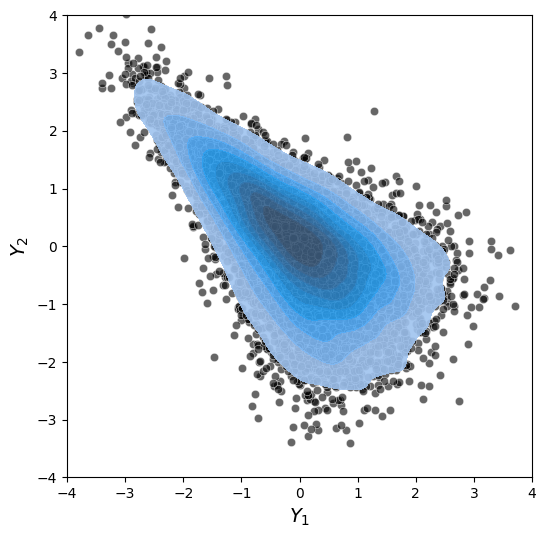

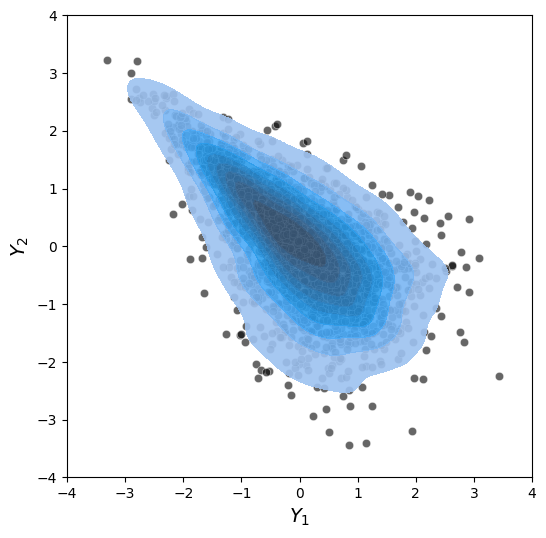

In [17]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [18]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


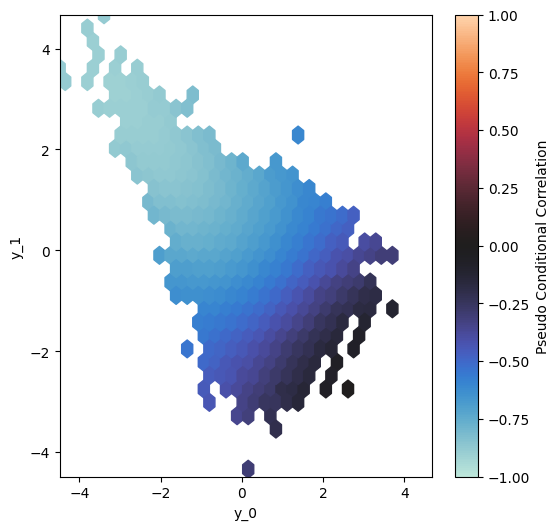

In [19]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


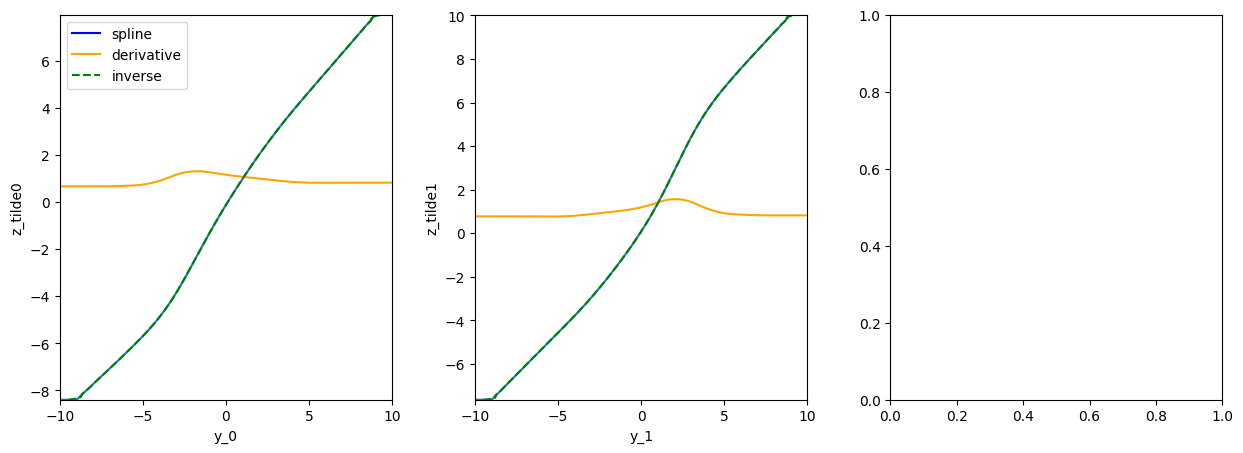

In [20]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


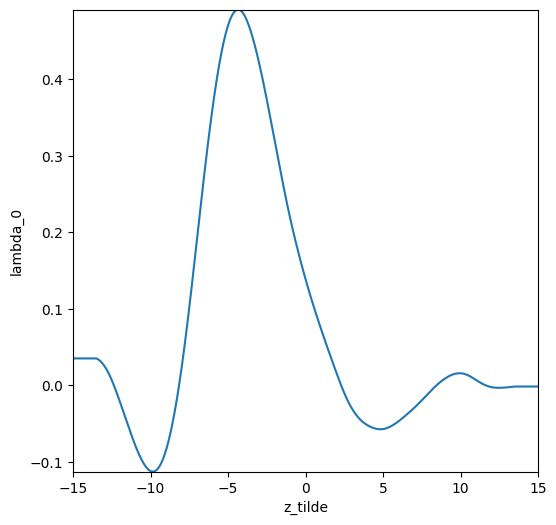

In [21]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


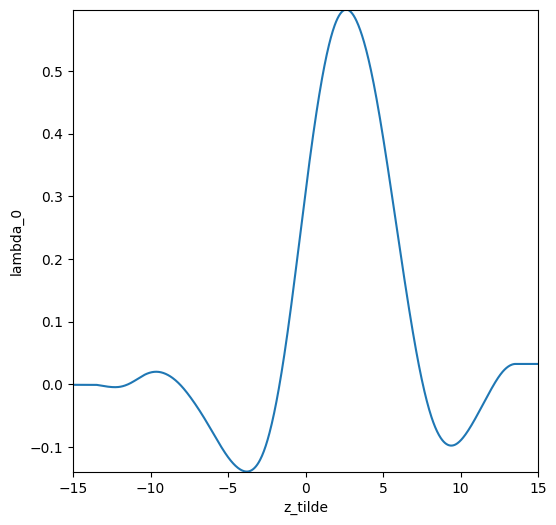

In [22]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


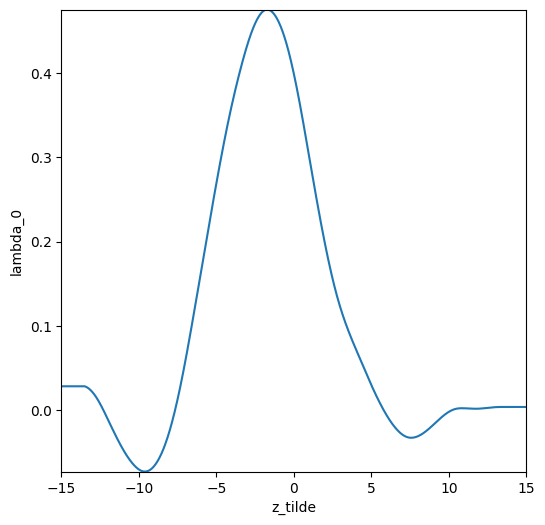

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)